In [2]:
!pip install U classiq

import classiq

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.1/77.1 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 151.6/151.6 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 387.9/387.9 kB 26.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 63.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 53.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 69.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.7/10.7 MB 70.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.4/6.4 MB 60.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 4

The algorithm is divided into two primary phases:

**Probability Distribution Phase:** This phase establishes the probability of the walker's movements.

**Execution Phase:** This phase executes the walker's movements based on the established probabilities.
Let’s break down each phase.

***Probability Distribution Phase***
In this phase, a quantum coin is "flipped" to determine the walker's movement probabilities. This operator adjusts the walker's state, assigning probabilities for moving left or right from each position. For instance, if the walker is at position 0, it will have a high probability of moving to position 1. Conversely, if the walker is at the position 15 which is the last node, it will have a high probability of moving to position 14. For intermediate positions, the probabilities are evenly split between moving left or right.

We configure the probabilities according to the aforementioned logic and utilize a quantum diffuser to amplify the probabilities of adjacent positions.

In [84]:
classiq.authenticate()

/usr/local/lib/python3.10/dist-packages/classiq/_internals/authentication/token_manager.py:99: UserWarning: Device is already registered.
Generating a new refresh token should only be done if the current refresh token is compromised.
To do so, set the overwrite parameter to true
  warnings.warn(


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

from classiq import *

In [72]:
from classiq import *
from classiq.qmod.symbolic import logical_or
from classiq.execution import ExecutionPreferences

In [73]:
numberofnodes = 2**4

In [91]:
@qfunc
def preparenegativestate(x: QBit):
    X(x)
    H(x)

def preparenegativestate  Prepares a qubit in a custom state.

In [76]:
@qfunc
def diffuserforgrover(help: Output[QNum],x:QNum):
    help^=(x!=0)

def diffuserforgrover implements a diffuser system
 for Grover's algorithm.

def zerodiffuser implements the zero diffuser for the quantum walk.


In [92]:
@qfunc
def zerodiffuser(x: QNum):

    help = QNum('help')
    allocate(1,help)
    within_apply(compute=lambda: preparenegativestate(help),
              action=lambda:diffuserforgrover )

def Citeration(i:int,vertices: QNum, adjacent_vertices:QNum):

    prob = [0]*numberofnodes
    if i == 0:
        prob[i + 1] = 1
    elif i == numberofnodes - 1:
        prob[i - 1] = 1
    else:
        prob[i - 1] = 0.5
        prob[i + 1] = 0.5
    print(f'Node={i}, prob vec ={prob}')
    control(ctrl=vertices==i,
            operand=lambda: within_apply(
              compute= lambda: inplace_prepare_state(probabilities=prob, bound=0.01, target=adjacent_vertices),
              action= lambda: zerodiffuser(adjacent_vertices)))

@qfunc
def C_operator(vertices:QNum, adjacent_vertices: QNum):
    for i in range(numberofnodes):
        Citeration(i,vertices,adjacent_vertices)



# **Execution Phase**
After establishing the movement probabilities, the execution phase begins. This phase involves moving the walker based on the set probabilities. If the quantum state indicates a move from position 8 to positions 9 and 7, the execution phase will adjust the state accordingly. During this phase, quantum interference can occur, where the probability amplitudes of different paths combine to either increase or decrease the likelihood of certain outcomes.

In [96]:
@qfunc
def edge_oracle(storethecheck:Output[QBit], vertices: QNum, adjacent_vertices: QNum):

    storethecheck |= (((vertices - adjacent_vertices) == 1) | ((vertices - adjacent_vertices) == -1))

@qfunc
def bitwise_swap(x: QArray[QBit], y:QArray[QBit]):

    repeat(count= x.len,
           iteration= lambda i: SWAP(x[i],y[i]))
@qfunc
def S_operator(vertices:QNum, adjacent_vertices: QNum):

    storethecheck = QNum('storethecheck')
    edge_oracle(storethecheck,vertices,adjacent_vertices)
    control(ctrl= storethecheck==1,
        operand= lambda: bitwise_swap(vertices,adjacent_vertices))

In the main def, the process starts by initializing the walker in a superposition of all possible positions along a line, typically using quantum gates like the Hadamard gate. This creates an equal probability amplitude for the walker to be at any of the 16 positions.

In [98]:
@qfunc
def main(vertices:Output[QNum], adjacent_vertices:Output[QNum]):

    allocate(4, vertices)
    hadamard_transform(vertices)
    allocate(4, adjacent_vertices)
    C_operator(vertices, adjacent_vertices)
    S_operator(vertices, adjacent_vertices)

Here is the implemented circuit!!!WHICH IS HUGE!!!!!

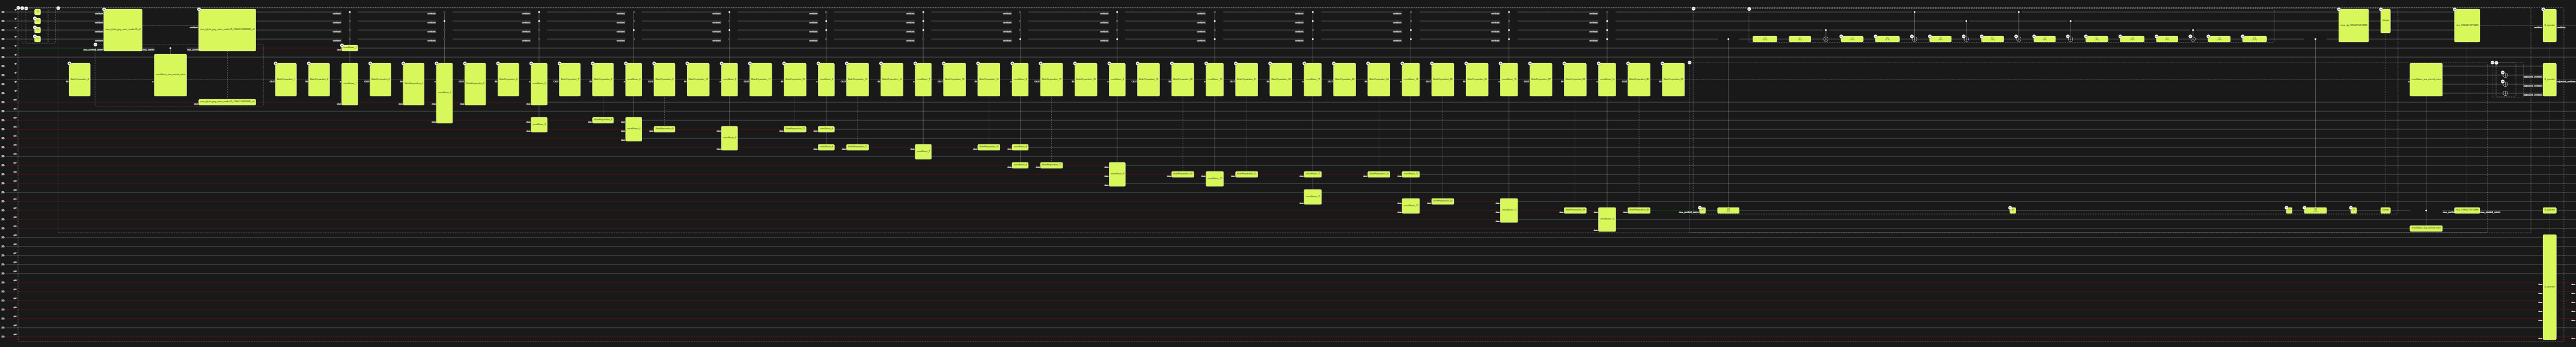

In [99]:
from classiq.execution import ExecutionPreferences
qmod = create_model(main)
qprog = synthesize(qmod)
show(qprog)

Node=0, prob vec =[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Node=1, prob vec =[0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Node=2, prob vec =[0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Node=3, prob vec =[0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Node=4, prob vec =[0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Node=5, prob vec =[0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Node=6, prob vec =[0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0]
Node=7, prob vec =[0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0]
Node=8, prob vec =[0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0]
Node=9, prob vec =[0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0]
Node=10, prob vec =[0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0]
Node=11, prob vec =[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0]
Node=12, prob vec =[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0]
Node=13, prob vec =[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0]
Node=1

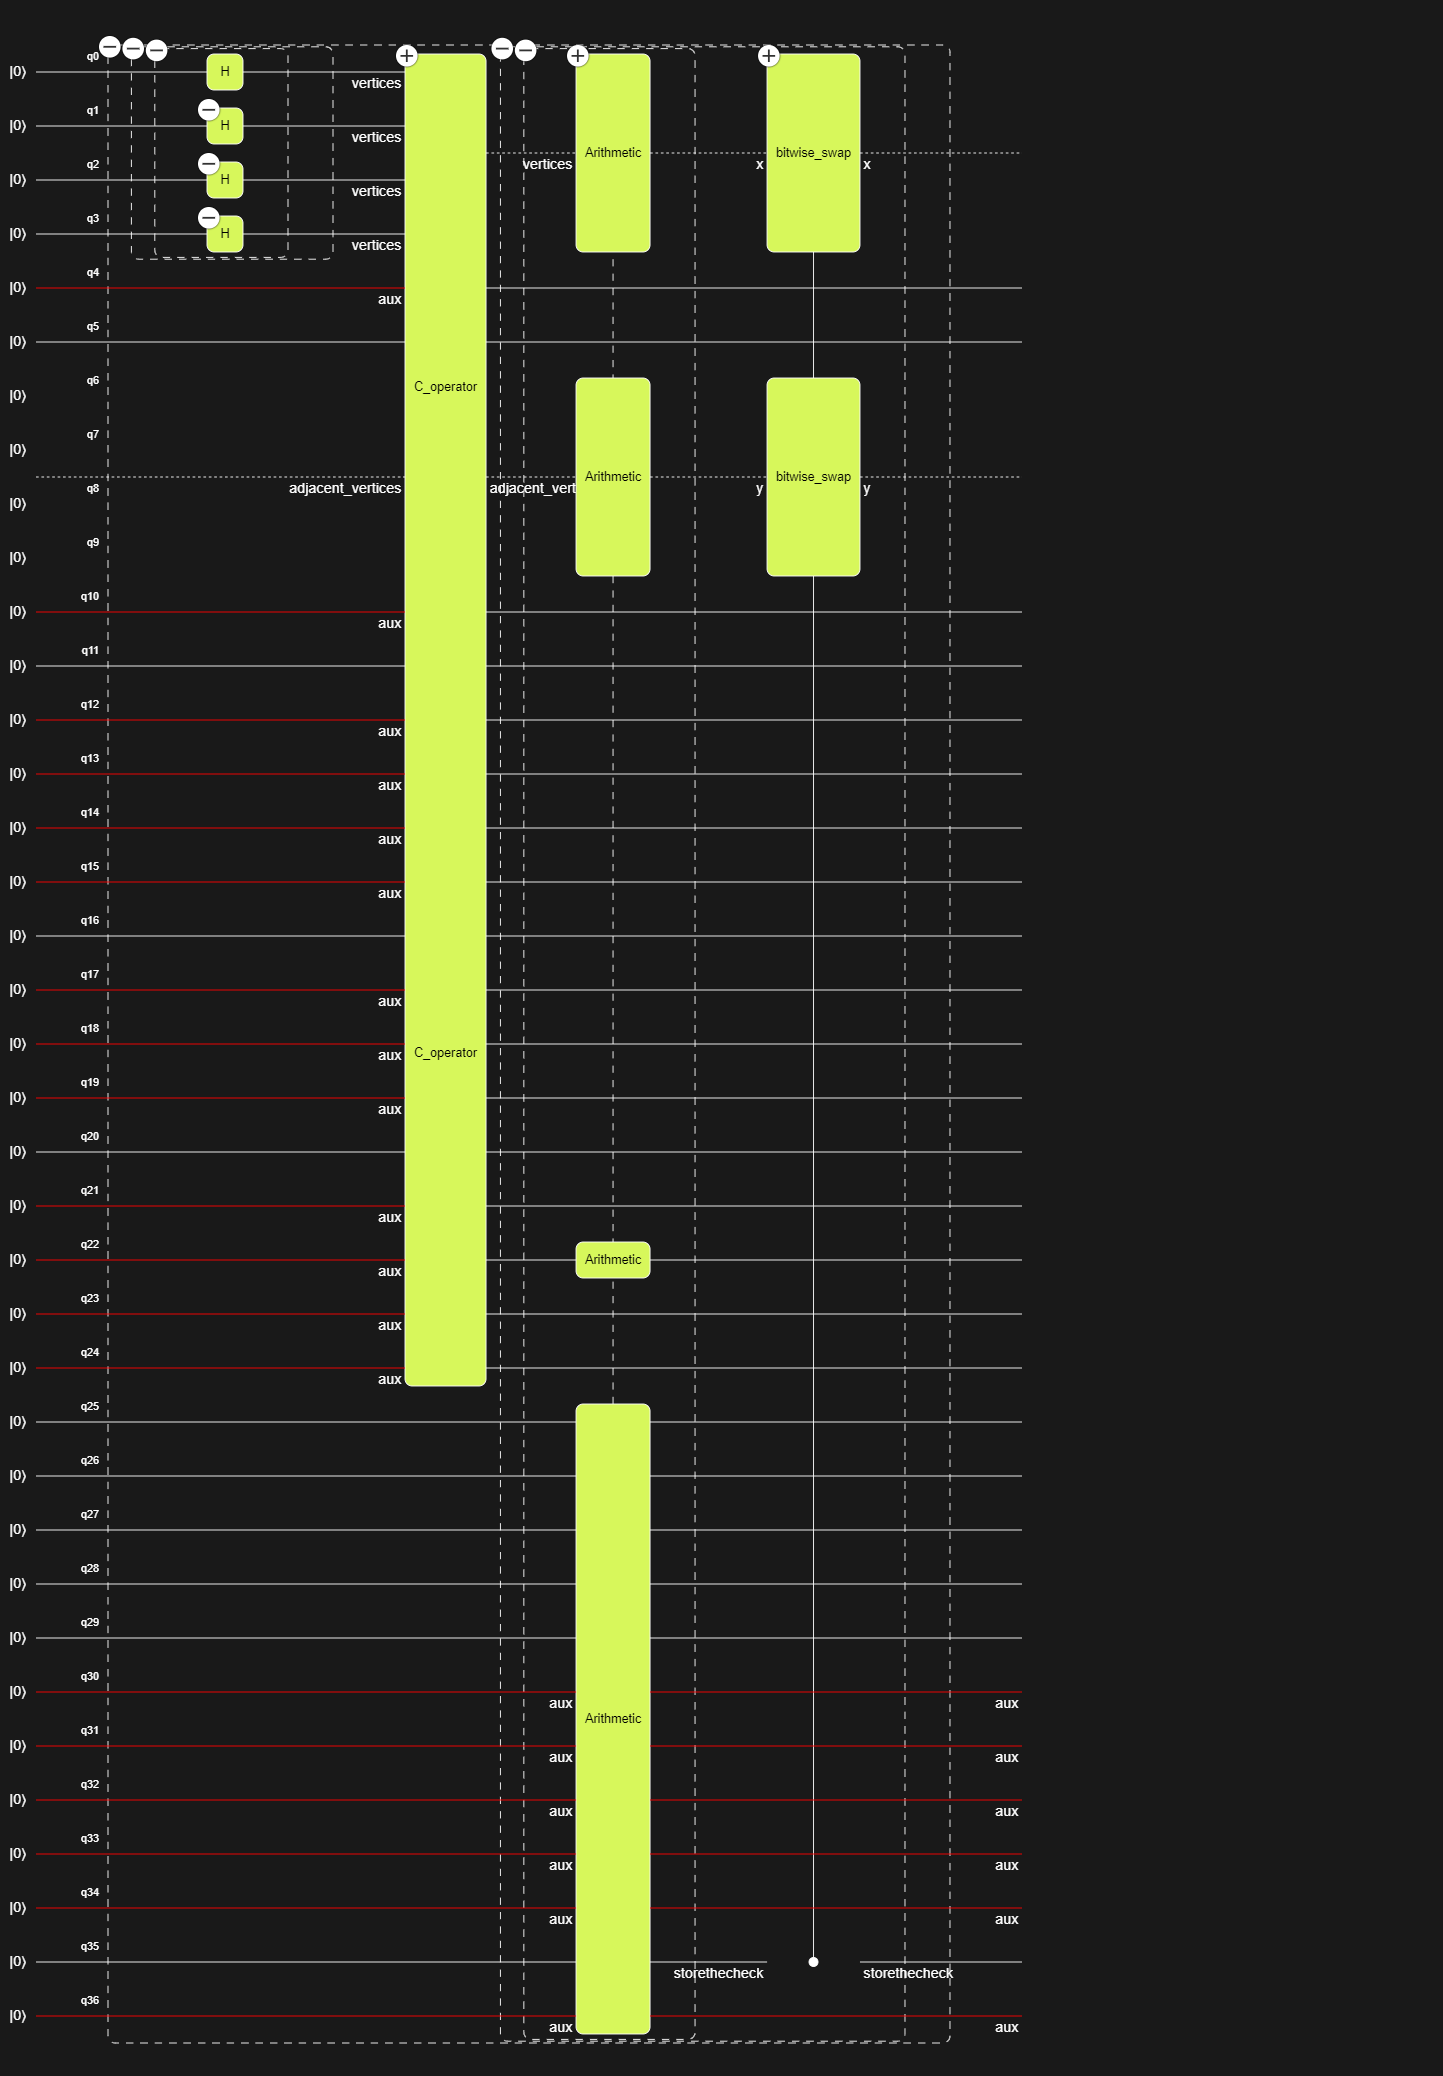

The circuit begins with Hadamard gates to create an equal probability for the walker to be at any of the 16 positions. The state preparation block sets up the probabilities for moving to adjacent nodes, and the zero diffuser ensures these probabilities are correctly distributed with the help of an auxiliary qubit. Sequentially, each node is prepared for the walk.

The shift operator is then implemented. The edge oracle checks if two vertices are adjacent, setting a flag if they are. Based on this check, the bitwise swap
operation exchanges the states of the vertices, simulating the walker's movement to an adjacent node. This ensures movement only occurs between adjacent vertices.


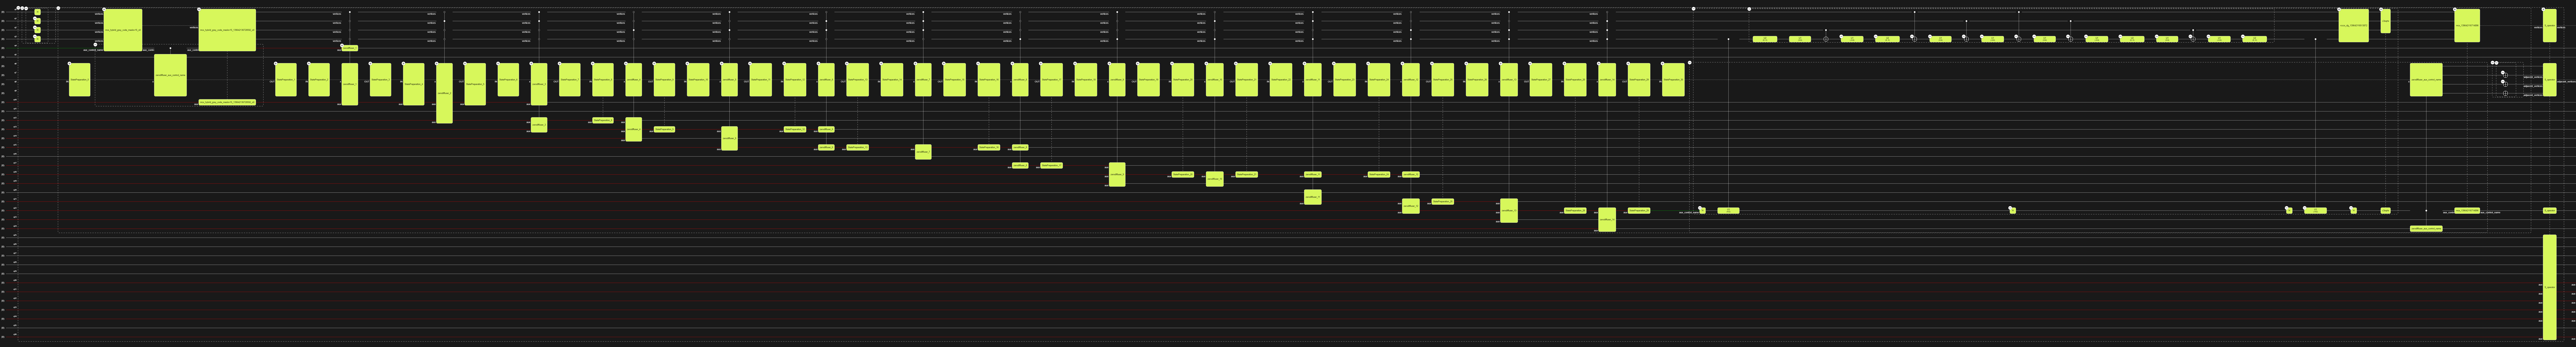